<a href="https://colab.research.google.com/github/G-Conard/ds595-final-project/blob/main/LSTM_Heat_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.patches as mpatches
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


import os

In [33]:
data = pd.read_csv('/content/weather_stations_data.csv')

In [34]:
data.columns

Index(['id', 'station_id', 'tempc', 'humidity', 'dewptc', 'windchillc',
       'winddir', 'windspeedkmh', 'windgustkmh', 'rainmm', 'dailyrainmm',
       'weeklyrainmm', 'monthlyrainmm', 'yearlyrainmm', 'solarradiation', 'UV',
       'indoortempc', 'indoorhumidity', 'absbarohpa', 'barohpa', 'rad_tempc',
       'rad_hum', 'aqpm25', 'heat_index', 'timestamp'],
      dtype='object')

In [35]:
data.head()

,id,station_id,tempc,humidity,dewptc,windchillc,winddir,windspeedkmh,windgustkmh,rainmm,...,UV,indoortempc,indoorhumidity,absbarohpa,barohpa,rad_tempc,rad_hum,aqpm25,heat_index,timestamp
0,22954.0,3.0,35.11,56.0,25.00,35.11,295.0,5.76,9.37,0.0,...,0.0,36.39,51.0,1010.30,1010.30,37.89,44.0,6.0,45.07,3/8/2024 16:08
1,22956.0,3.0,35.50,57.0,25.72,35.50,217.0,3.60,7.19,0.0,...,0.0,36.28,53.0,1010.19,1010.19,37.89,47.0,8.0,46.62,3/8/2024 16:13
2,22958.0,3.0,35.50,56.0,25.39,35.50,236.0,5.76,9.37,0.0,...,0.0,36.22,54.0,1010.19,1010.19,37.89,47.0,8.0,46.62,3/8/2024 16:19
3,22960.0,3.0,34.61,56.0,24.61,34.61,276.0,2.88,7.19,0.0,...,0.0,36.11,51.0,1010.19,1010.19,37.22,45.0,5.0,43.89,3/8/2024 16:24
4,22962.0,3.0,33.78,57.0,24.11,33.78,242.0,1.80,7.19,0.0,...,0.0,35.78,52.0,1010.30,1010.30,35.61,50.0,5.0,42.16,3/8/2024 16:29


In [36]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

In [37]:
data = data[['heat_index' ]]

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23819 entries, 2024-03-08 16:08:00 to NaT
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   heat_index  6867 non-null   float64
dtypes: float64(1)
memory usage: 372.2 KB


In [39]:
from scipy.interpolate import interp1d

In [40]:
data = data.dropna()

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6867 entries, 2024-03-08 16:08:00 to 2024-04-02 19:04:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   heat_index  6867 non-null   float64
dtypes: float64(1)
memory usage: 107.3 KB


In [42]:
data.head()

,heat_index
timestamp,
2024-03-08 16:08:00,45.07
2024-03-08 16:13:00,46.62
2024-03-08 16:19:00,46.62
2024-03-08 16:24:00,43.89
2024-03-08 16:29:00,42.16


In [43]:
df=data.copy()

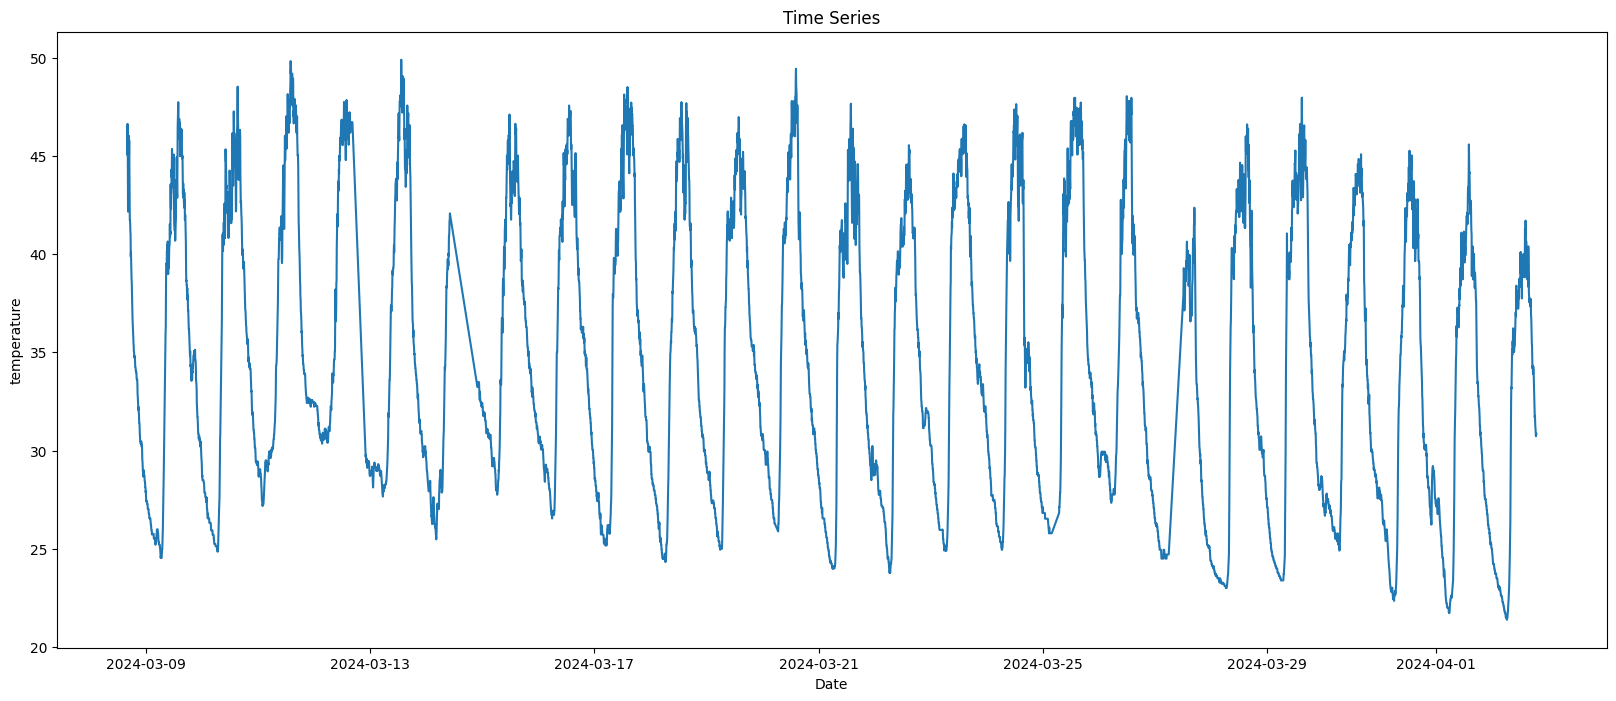

In [44]:
plt.figure(figsize=(20,8))
plt.plot(data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.show()

In [45]:
data=data.values
data = data.astype('float32')

In [46]:
scaler= MinMaxScaler(feature_range=(-1,1))
sc = scaler.fit_transform(data)

In [47]:
sc

array([[ 0.66175437],
       [ 0.7705262 ],
       [ 0.7705262 ],
       ...,
       [-0.34456134],
       [-0.33403516],
       [-0.3361404 ]], dtype=float32)

In [57]:
timestep = 288  # This is the correct number of timesteps for 24 hours of data at 5-minute intervals

X = []
Y = []

for i in range(len(sc) - timestep):
    X.append(sc[i:(i + timestep)])
    Y.append(sc[i + timestep])

X = np.array(X)
Y = np.array(Y)

# Split the dataset into training and test sets
k = int(0.8 * len(X))  # For an 80/20 split
Xtrain = X[:k, :, None]  # Adding the 'None' to create a 3rd dimension for features
Xtest = X[k:, :, None]
Ytrain = Y[:k]
Ytest = Y[k:]


In [58]:
print(Xtrain.shape)
print(Xtest.shape)

(5263, 288, 1, 1)
(1316, 288, 1, 1)


In [59]:
from keras import layers

from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [60]:
model = Sequential()

model.add(LSTM(32, activation='relu', input_shape=(288, 1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 288, 32)           4352      
                                                                 
 lstm_10 (LSTM)              (None, 288, 32)           8320      
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
history = model.fit(Xtrain,Ytrain,epochs=50, verbose=1)

Epoch 1/50
165/165 [==============================] - 51s 287ms/step - loss: 0.1724
Epoch 2/50
165/165 [==============================] - 50s 305ms/step - loss: 0.0112
Epoch 3/50
165/165 [==============================] - 54s 325ms/step - loss: 0.0083
Epoch 4/50
165/165 [==============================] - 57s 342ms/step - loss: 0.0067
Epoch 5/50
165/165 [==============================] - 53s 318ms/step - loss: 0.0057
Epoch 6/50
165/165 [==============================] - 52s 316ms/step - loss: 0.0050
Epoch 7/50
165/165 [==============================] - 55s 334ms/step - loss: 0.0044
Epoch 8/50
165/165 [==============================] - 55s 334ms/step - loss: 0.0037
Epoch 9/50
165/165 [==============================] - 57s 349ms/step - loss: 0.0035
Epoch 10/50
165/165 [==============================] - 50s 300ms/step - loss: 0.0032
Epoch 11/50
165/165 [==============================] - 49s 299ms/step - loss: 0.0031
Epoch 12/50
165/165 [==============================] - 49s 295ms/step - lo

Text(0.5, 1.0, 'Model Accuracy')

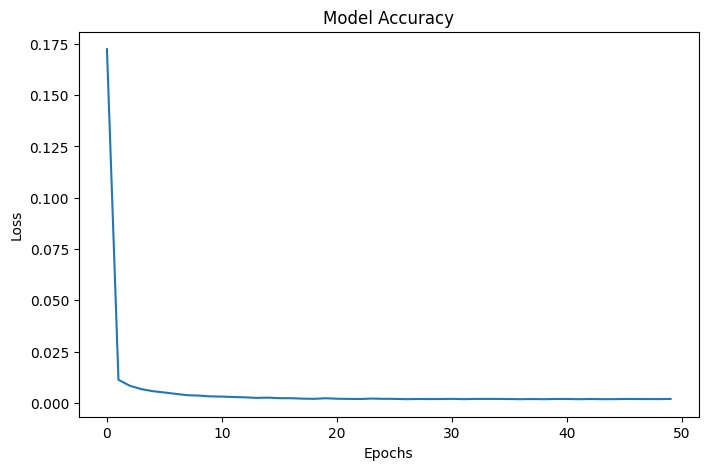

In [63]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [64]:
preds= model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)
Ytest=Ytest.reshape(-1,1)
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)
Ytrain=Ytrain.reshape(-1,1)
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

42/42 [==============================] - 4s 92ms/step


0.36052427

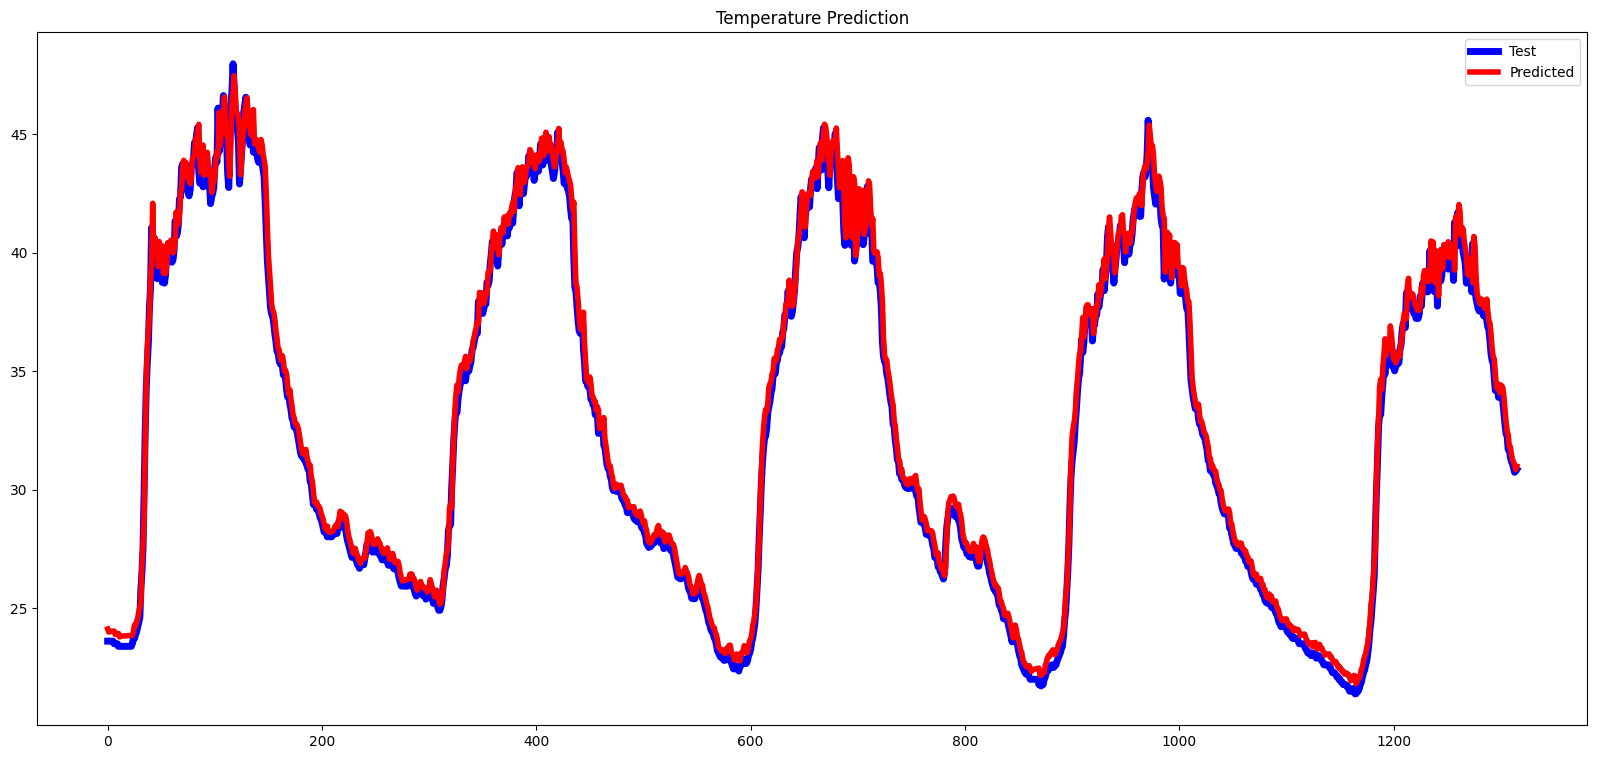

In [65]:
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()